# Exercise 6 - Pixel classification and object segmentation

In the first part of this exercise, we will use pixel classification to label pixels in an image. In the second part, pixel classification will be combined with BLOB analysis to segment the spleen from a computed tomography (CT) scan.

## Installing Python packages

In [1]:
from skimage import io, color
from skimage.morphology import binary_closing, binary_opening
from skimage.morphology import disk
import matplotlib.pyplot as plt
import numpy as np
from skimage import measure
from skimage.color import label2rgb
import pydicom as dicom
from scipy.stats import norm
from scipy.spatial import distance
import statistics


def show_comparison(original, modified, modified_name):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4), sharex=True,
                                   sharey=True)
    ax1.imshow(original, cmap="gray", vmin=-200, vmax=500)
    ax1.set_title('Original')
    ax1.axis('off')
    ax2.imshow(modified)
    ax2.set_title(modified_name)
    ax2.axis('off')
    io.show()

## Abdominal computed tomography

The images in this exercise are DICOM images from a computed tomography (CT) scan of the abdominal area. An example can be seen below, where the anatomies we are working with are marked. 

A CT scan is normally a 3D volume with many slices, but in this exercise, we will only work with one slice at a time. We therefore call one slice for an image.

In this exercise, we will mostly focus on the spleen but also examine the liver, kidmeys, fat tissue and bone.

### Hounsfield units
The pixels in the images are stored as 16-bit integers, meaning their values can be in the range of [-32.768, 32.767]. In a CT image, the values are represented as Hounsfield units (HU). Hounsfield units are used in computed tomography to characterise the X-ray absoorption of different tissues. A CT scanner is normally calibrated so a pixel with Hounsfield unit 0 has an absorbance equal to water and a pixel with Hounsfield unit -1000 has an absorbance equal to air. Bone absorbs a lot of radiation and therefore have high HU values (300-800) and fat absorbs less radiation than water and has HU units around -100. Several organs have similar HU values since the soft-tissue composition of the organs have similar X-ray absorption. In the figure below (from Erich Krestel, "Imaging Systems for Medical Diagnostics", 1990, Siemens) some typical HU units for organs can be seen. They are, however, not always consistent from scanner to scanner and hospital to hospital.

### Explorative analysis of one CT scan

Let us start by examining one of the CT scan slides from the training set. You can read the first slice like this:

In [2]:
in_dir = "data/"
ct = dicom.read_file(in_dir + 'Training.dcm')
img = ct.pixel_array
print(img.shape)
print(img.dtype)

(512, 512)
int16


You should visualise the slice, so the organs of interest have a suitable brigthness and contrast. One way is to manipulate the minimum and maximum values proviede to imshow.

##### Exercise 1: 
The spleen typically has to HU units in the range of 0 to 150. Try to make a good visualization of the CT scan and spleen using (replace the question marks with values):

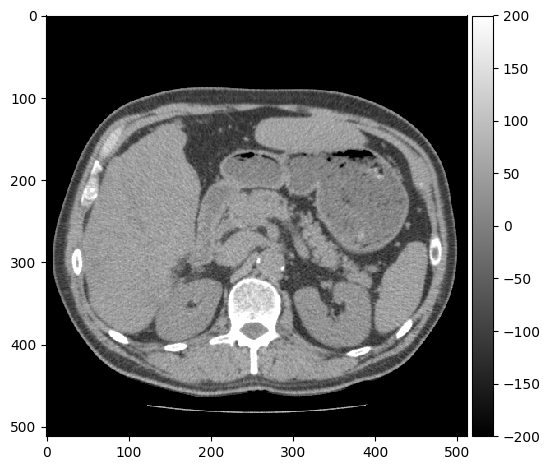

In [3]:
io.imshow(img, vmin=-200, vmax=200, cmap='gray')
io.show()

An expert has provided annotations of bone, fat, kidneys, liver and spleen. They are stored as mask files which is an image with the same sieze as the input image, where the annotated pixels are 1 and the rest are 0. They are found as BoneROI.png, FatROI.png, KidneyROI.png, LiverROI and SpleenROI.png.

You can use the original image and a mask to get the values of the pixels inside the mask:

In [4]:
spleen_roi = io.imread(in_dir + 'SpleenROI.png')
# convert to boolean image
spleen_mask = spleen_roi > 0
spleen_values = img[spleen_mask]

##### Exercise 2:
Compute the average and standard deviation of the Hounsfield units found in the spleen in the training image. Do they correspond to the values found in the above figure?

In [5]:
mu_spleen = np.mean(spleen_values)
std_spleen = np.std(spleen_values)
print(f"The spleen mean is: {mu_spleen}; The spleen standard deviation is: {std_spleen}")

The spleen mean is: 49.48026905829597; The spleen standard deviation is: 14.9970794143059


##### Exercise 3:
Plot a histogram of the pixel values of the spleen. Does it look like they are Gaussian distributed?

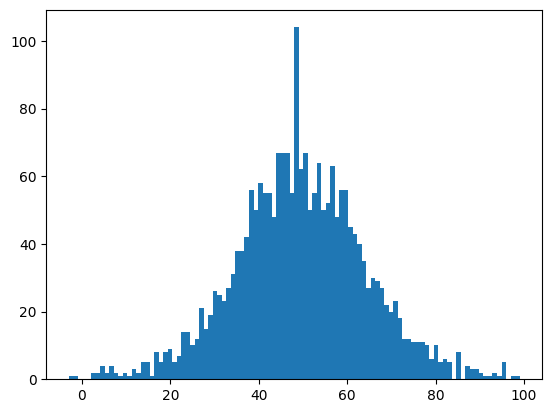

In [6]:
plt.hist(spleen_values, bins=100)
io.show()

The function norm.pdf from SciPy repreesntes a Gaussian probability density function (PDF). It can for example be used to plot a Gaussian distribution with a given mean and standard deviation.

This can be used to create a fitted Gaussian distribution of the spleen values:

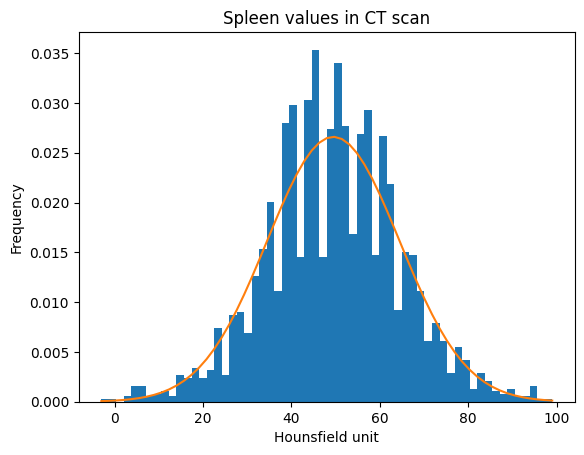

In [27]:
n, bins_spleen, patches = plt.hist(spleen_values, 60, density=1)
pdf_spleen = norm.pdf(bins_spleen, mu_spleen, std_spleen)
plt.plot(bins_spleen, pdf_spleen)
plt.xlabel('Hounsfield unit')
plt.ylabel('Frequency')
plt.title('Spleen values in CT scan')
plt.show()

Here, mu_spleen and std_spleen are the average and standard deviation of the spleen values.

##### Exercise 4:
Plot histograms and their fitted Gaussians of several of the tissues types. Do they all look like they are Gaussian distributed?


The spleen mean is: -1011.1688530104271; The spleen standard deviation is: 18.96474889282835


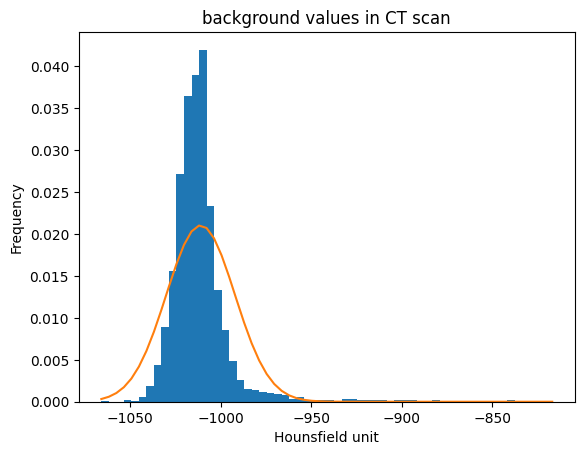

In [28]:
background_roi = io.imread(in_dir + 'backgroundROI.png')
# convert to boolean image
background_mask = background_roi > 0
background_values = img[background_mask]
mu_background = np.mean(background_values)
std_background = np.std(background_values)
print(f"The spleen mean is: {mu_background}; The spleen standard deviation is: {std_background}")

n, bins_background, patches = plt.hist(background_values, 60, density=1)
pdf_background = norm.pdf(bins_background, mu_background, std_background)
plt.plot(bins_background, pdf_background)
plt.xlabel('Hounsfield unit')
plt.ylabel('Frequency')
plt.title('background values in CT scan')
plt.show()

The bone mean is: 766.9375; The spleen standard deviation is: 116.56353886936515


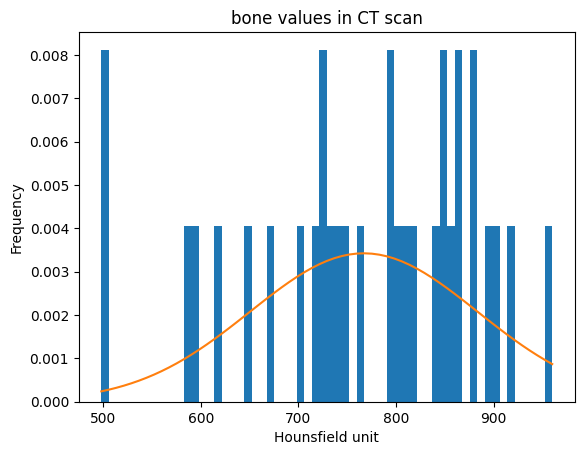

In [29]:
bone_roi = io.imread(in_dir + 'boneROI.png')
# convert to boolean image
bone_mask = bone_roi > 0
bone_values = img[bone_mask]
mu_bone = np.mean(bone_values)
std_bone = np.std(bone_values)
print(f"The bone mean is: {mu_bone}; The spleen standard deviation is: {std_bone}")

n, bins_bone, patches = plt.hist(bone_values, 60, density=1)
pdf_bone = norm.pdf(bins_bone, mu_bone, std_bone)
plt.plot(bins_bone, pdf_bone)
plt.xlabel('Hounsfield unit')
plt.ylabel('Frequency')
plt.title('bone values in CT scan')
plt.show()

The fat mean is: -103.39037725533078; The fat standard deviation is: 11.323207120153308


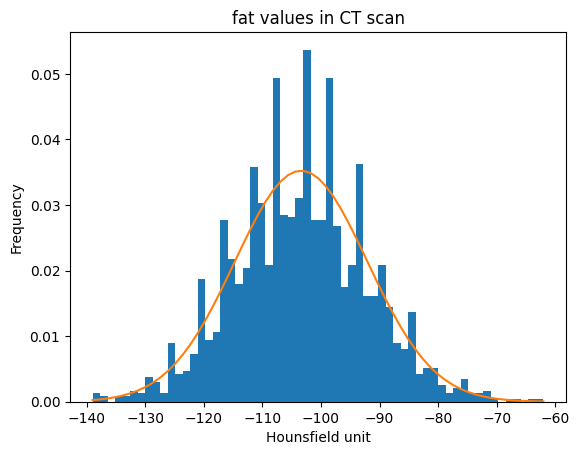

In [30]:
fat_roi = io.imread(in_dir + 'fatROI.png')
# convert to boolean image
fat_mask = fat_roi > 0
fat_values = img[fat_mask]
mu_fat = np.mean(fat_values)
std_fat = np.std(fat_values)
print(f"The fat mean is: {mu_fat}; The fat standard deviation is: {std_fat}")

n, bins_fat, patches = plt.hist(fat_values, 60, density=1)
pdf_fat = norm.pdf(bins_fat, mu_fat, std_fat)
plt.plot(bins_fat, pdf_fat)
plt.xlabel('Hounsfield unit')
plt.ylabel('Frequency')
plt.title('fat values in CT scan')
plt.show()

The kidney mean is: 29.614603174603175; The kidney standard deviation is: 15.31612003018511


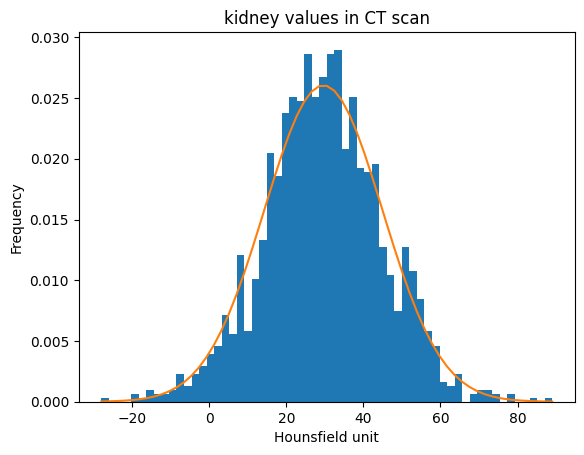

In [31]:
kidney_roi = io.imread(in_dir + 'kidneyROI.png')
# convert to boolean image
kidney_mask = kidney_roi > 0
kidney_values = img[kidney_mask]
mu_kidney = np.mean(kidney_values)
std_kidney = np.std(kidney_values)
print(f"The kidney mean is: {mu_kidney}; The kidney standard deviation is: {std_kidney}")

n, bins_kidney, patches = plt.hist(kidney_values, 60, density=1)
pdf_kidney = norm.pdf(bins_kidney, mu_kidney, std_kidney)
plt.plot(bins_kidney, pdf_kidney)
plt.xlabel('Hounsfield unit')
plt.ylabel('Frequency')
plt.title('kidney values in CT scan')
plt.show()

The liver mean is: 45.40611510791367; The liver standard deviation is: 15.35346721138944


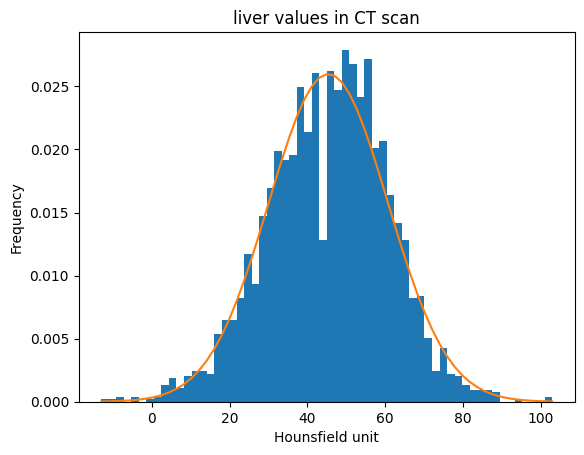

In [32]:
liver_roi = io.imread(in_dir + 'liverROI.png')
# convert to boolean image
liver_mask = liver_roi > 0
liver_values = img[liver_mask]
mu_liver = np.mean(liver_values)
std_liver = np.std(liver_values)
print(f"The liver mean is: {mu_liver}; The liver standard deviation is: {std_liver}")

n, bins_liver, patches = plt.hist(liver_values, 60, density=1)
pdf_liver = norm.pdf(bins_liver, mu_liver, std_liver)
plt.plot(bins_liver, pdf_liver)
plt.xlabel('Hounsfield unit')
plt.ylabel('Frequency')
plt.title('liver values in CT scan')
plt.show()

The fitted Gaussians are good for inspecting class separation and how much the class overlap. Plotting several fitted Gaussians can for example be done like this:

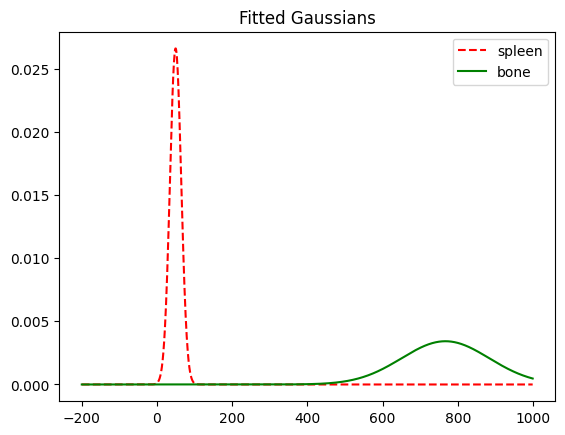

In [18]:
# Hounsfield unit limits of the plot
min_hu = -200
max_hu = 1000
hu_range = np.arange(min_hu, max_hu, 1.0)
pdf_spleen = norm.pdf(hu_range, mu_spleen, std_spleen)
pdf_bone = norm.pdf(hu_range, mu_bone, std_bone)
plt.plot(hu_range, pdf_spleen, 'r--', label="spleen")
plt.plot(hu_range, pdf_bone, 'g', label="bone")
plt.title("Fitted Gaussians")
plt.legend()
plt.show()

##### Exercise 5:
Plot the fitted Gaussians of bone, fat, kidneys, liver and spleen. What classes area easy to separate and which classes are hard to separate?

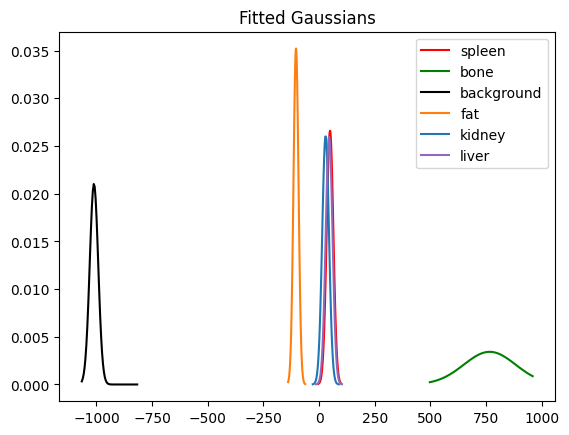

In [34]:
# Hounsfield unit limits of the plot
min_hu = -200
max_hu = 1000
hu_range = np.arange(min_hu, max_hu, 1.0)

plt.plot(bins_spleen, pdf_spleen, 'r', label="spleen")
plt.plot(bins_bone, pdf_bone, 'g', label="bone")
plt.plot(bins_background, pdf_background, 'k', label='background')
plt.plot(bins_fat, pdf_fat, 'tab:orange', label="fat")
plt.plot(bins_kidney, pdf_kidney, 'tab:blue', label="kidney")
plt.plot(bins_liver, pdf_liver, "tab:purple", label="liver")

plt.title("Fitted Gaussians")
plt.legend()
plt.show()

##### Exercise 6:
Define the classes that we aim at classifying. Perhaps some classes should be combined into one class?

#### Minimum distance pixel classification
In the minimum distancce classifier the pixel value class ranges are defined using the average values of the training values. If you have two classes, the threshold between them is defined as the mid-point between the two class value averages.

In the following, we will define four classes: background, fat, soft issue and bone, where soft-tissue is a combination of the values of the spleen, liver and kidneys. We manually set the threshold for background to -200. So all pixels below -200 are set to background. 

##### Exercise 7
Compute the class ranges defininf fat, soft issue and bone. You can now use:

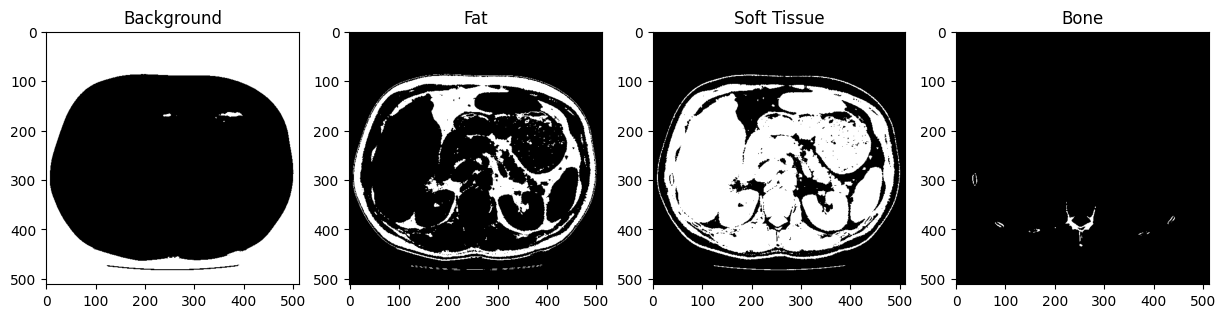

In [38]:
soft_tissue_values = np.append(kidney_values, spleen_values)
soft_tissue_values = np.append(soft_tissue_values, liver_values)
(mu_soft, std_soft) = norm.fit(soft_tissue_values)

t_background = -200
#t_fat_soft = -60
#t_bone = 250
t_fat_soft = (mu_fat + mu_soft) / 2.0
t_bone = (mu_soft + mu_bone) / 2.0 
background_img = (img <=t_background)
fat_img = (img > t_background) & (img <=t_fat_soft)
soft_img = (img > t_fat_soft) & (img <=t_bone)
bone_img = (img > t_bone)

fig, ax = plt.subplots(1, 4, figsize = (15, 5))
ax[0].imshow(background_img, cmap = "gray")
ax[0].set_title("Background")
ax[1].imshow(fat_img, cmap = "gray")
ax[1].set_title("Fat")
ax[2].imshow(soft_img, cmap = "gray")
ax[2].set_title("Soft Tissue")
ax[3].imshow(bone_img, cmap = "gray")
ax[3].set_title("Bone")
plt.show()

##### Exercise 8:
Create class images: fat_img, soft_img and bone_img representing the fat, soft tissuel and bone found in the image.

To visualize the classification results you can use:

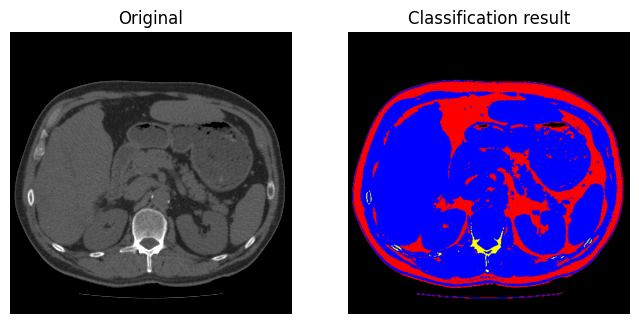

In [39]:
label_img = fat_img + 2*soft_img +3*bone_img
image_label_overlay = label2rgb(label_img)
show_comparison(img, image_label_overlay, "Classification result")

#### Parametric pixel classification

In the parametric classifier, the standard deviation of the training pixel values is also used when determinin the class ranges. In the following, we are also trying to classify background, fat, soft tissue and bone.

We start by finding the class ranges by manually inspecting the fitted Gaussians from each class.

As in the last exercise, we can still see the background-fat threshold to be -200.

##### Exercise 9: 
Plot the fitted Gaussians of the training values and manually find the intersection between the curves.

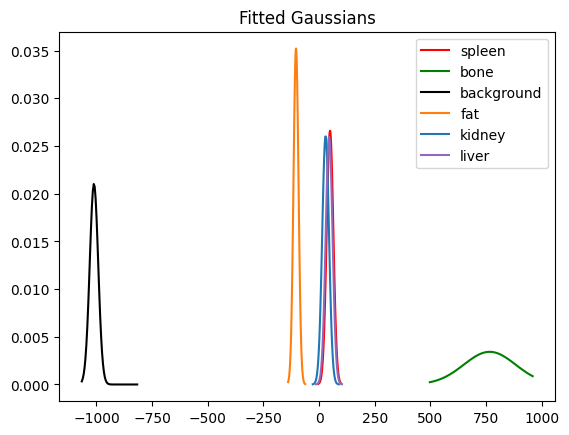

In [40]:
plt.plot(bins_spleen, pdf_spleen, 'r', label="spleen")
plt.plot(bins_bone, pdf_bone, 'g', label="bone")
plt.plot(bins_background, pdf_background, 'k', label='background')
plt.plot(bins_fat, pdf_fat, 'tab:orange', label="fat")
plt.plot(bins_kidney, pdf_kidney, 'tab:blue', label="kidney")
plt.plot(bins_liver, pdf_liver, "tab:purple", label="liver")

plt.title("Fitted Gaussians")
plt.legend()
plt.show()

##### Exercise 10
Use the same technique as in exercise 7, 8 and 9 to visualize your classification results. Did it change compared to the minimum distance classifier?

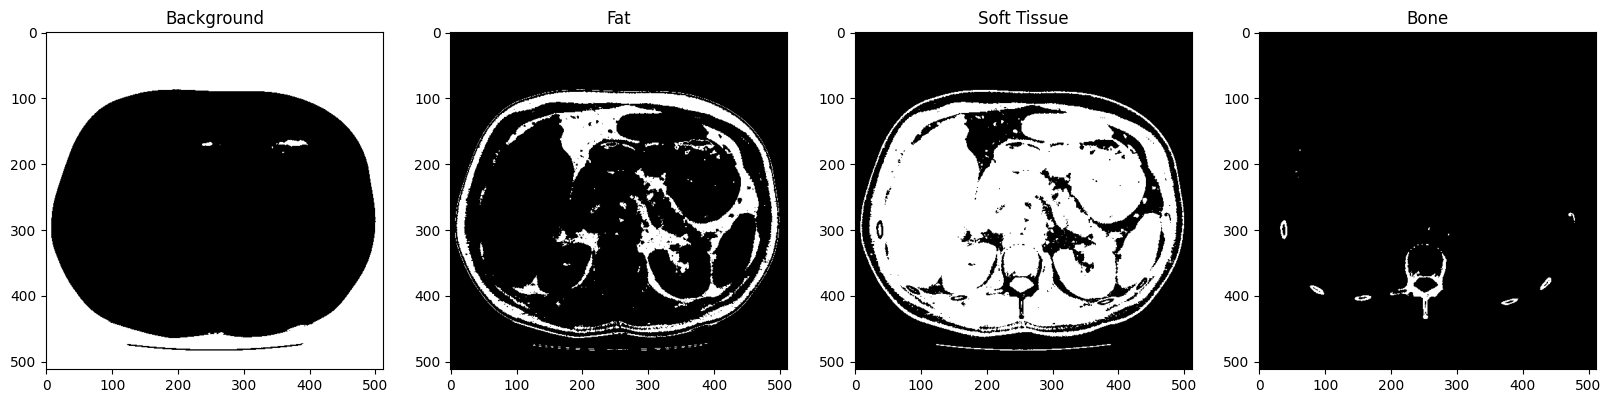

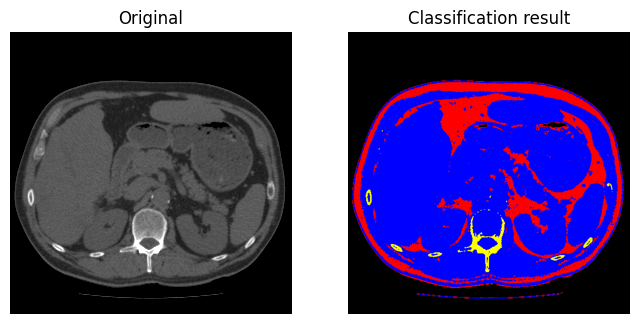

In [44]:

t_background = -200
t_fat_soft = -60
t_bone = 250

background_img = (img <=t_background)
fat_img = (img > t_background) & (img <=t_fat_soft)
soft_img = (img > t_fat_soft) & (img <=t_bone)
bone_img = (img > t_bone)

fig, ax = plt.subplots(1, 4, figsize = (20, 20))
ax[0].imshow(background_img, cmap = "gray")
ax[0].set_title("Background")
ax[1].imshow(fat_img, cmap = "gray")
ax[1].set_title("Fat")
ax[2].imshow(soft_img, cmap = "gray")
ax[2].set_title("Soft Tissue")
ax[3].imshow(bone_img, cmap = "gray")
ax[3].set_title("Bone")
plt.show()

label_img = fat_img + 2*soft_img +3*bone_img
image_label_overlay = label2rgb(label_img)
show_comparison(img, image_label_overlay, "Classification result")

An alternative way of finding the class ranges is to test which class has the highest probability for a given value. The norm.pdf function can be used for that. For example:

In [ ]:
if norm.pdf(test_value, mu_soft, std_soft) > norm.pdf(test_value, mu_bone, std_bone):
	print(f"For value {test_value} the class is soft tissue")
else:
	print(f"For value {test_value} the class is bone")

here the test_value is a pixel value that you want to assign a class. One way to use this is to create a look-up-table where for each possible HU unit (for example 100,101,102 etc), the most probably class is noted. Doing this will give you the pixel value where the two neighbouring classes met.

##### Exercise 11
Use norm.pdf to find the optimal class ranges between fat, soft tissue and bone

In [69]:
np.arange(min(bins_background), max(bins_bone), 0.1)

array([-1066. , -1065.9, -1065.8, ...,   959.7,   959.8,   959.9])

In [74]:
flag = np.zeros(len(np.arange(min(bins_fat), max(bins_bone), 0.1)))
fat_soft_flag = 0
soft_bone_flag = 0
for test_value in np.arange(min(bins_fat), max(bins_bone), 0.1):
	#if (norm.pdf(test_value, mu_fat, std_fat) > norm.pdf(test_value, mu_soft, std_soft)) and (norm.pdf(test_value, mu_fat, std_fat) > norm.pdf(test_value, mu_bone, std_bone)):
		#print(f"For value {test_value} the class is fat tissue")
	if (norm.pdf(test_value, mu_soft, std_soft) > norm.pdf(test_value, mu_bone, std_bone)) and (norm.pdf(test_value, mu_soft, std_soft) > norm.pdf(test_value, mu_fat, std_fat)) :
		#print(f"For value {test_value} the class is soft tissue")
		if fat_soft_flag == 0:
			fat_soft_flag = test_value
	elif (norm.pdf(test_value, mu_bone, std_bone) > norm.pdf(test_value, mu_fat, std_fat)) and (norm.pdf(test_value, mu_bone, std_bone) > norm.pdf(test_value, mu_soft, std_soft)):
		#print(f"For value {test_value} the class is bone")
		if soft_bone_flag == 0:
			soft_bone_flag = test_value
print(f"For values less than {fat_soft_flag:.2f} the tissue is fat, for values bigger than {fat_soft_flag:.2f} and smaller than {soft_bone_flag:.2f} the tissue is soft, and for values bigger than {soft_bone_flag:.2f} the tissue is bone")


For values less than -44.40 the tissue is fat, for values bigger than -44.40 and smaller than 140.70 the tissue is soft, and for values bigger than 140.70 the tissue is bone


#### Object Segmentation - The spleen finder
The goal of this part of the exercise, is to create a program that can automatically segment the spleen in CT images.

We start by using the Training.dcm image and the expert provided annotations.

##### Exercise 11
Inspect the values of the spleen as in exercise 3 and select a lower and upper threshold to create a spleen class range.

You can now use:

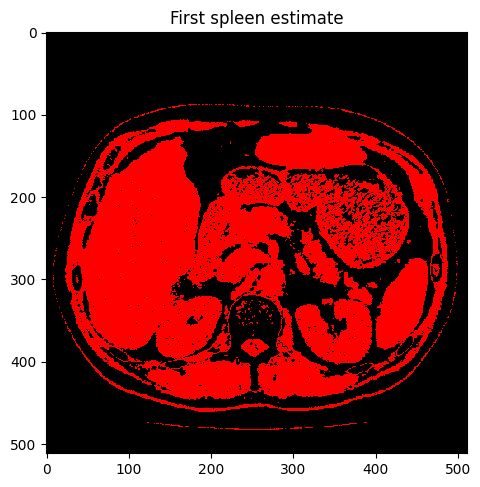

In [85]:
t_1 = min(bins_spleen)
t_2 = max(bins_spleen)
spleen_estimate = (img > t_1) & (img < t_2)
spleen_label_colour = color.label2rgb(spleen_estimate)
io.imshow(spleen_label_colour)
plt.title("First spleen estimate")
io.show()

to show your first spleen estimate. As can be seen, there are many non-spleen areas in the result. The spleen is also connected to another anatomy.

Luckily, we can use morphological operations to fix these issues:

##### Exercise 12
Use the above morphological operations to separete the spleen from other organs and close holes. Change the values where there are question marks to change the size of the used structuring elements.

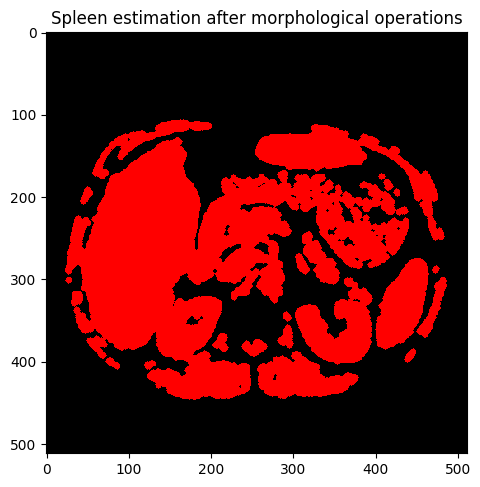

In [92]:
footprint = disk(1)
closed = binary_closing(spleen_estimate, footprint)

footprint = disk(4)
opened = binary_opening(closed, footprint)

spleen_label_colour = color.label2rgb(opened)
io.imshow(spleen_label_colour)
plt.title("Spleen estimation after morphological operations")
io.show()

Now we can use BLOB analysis to do a fetaure based classification of the spleen. 
##### Exercise 12: Usee the methods from BLOB analaysis to compute BLOB features for every separated BLOB in the image. You can for example start by:

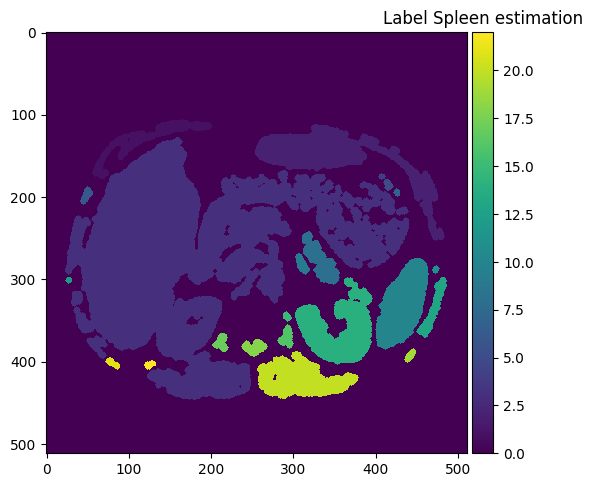

In [93]:
label_img = measure.label(opened)
io.imshow(label_img)
plt.title("Label Spleen estimation")
io.show()

##### Exercise 13:
 Inspect the labeled image and validate the success of separating the spleen from the other objects. If it is connected (have the same color) to another organ, you should experiment with the kernel sizes in the morphological operations.

To be able to keep only the spleen we need to find out which BLOB features, that is special for the spleen. By using measure.regionprops many different BLOB features can be computed, including area and perimeter.

You can for example use:

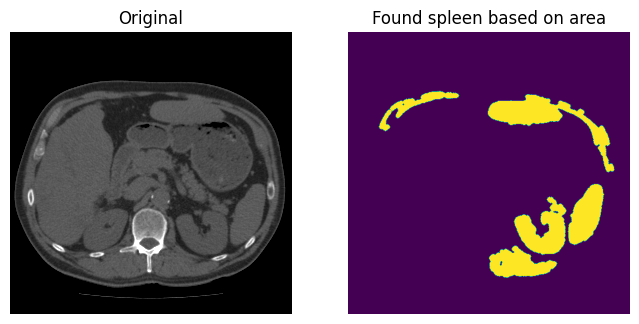

In [94]:
min_area = 2000
max_area = 10000


# Create a copy of the label_img
label_img_filter = label_img.copy()
region_props = measure.regionprops(label_img_filter)
for region in region_props:
	# Find the areas that do not fit our criteria
	if region.area > max_area or region.area < min_area:
		# set the pixels in the invalid areas to background
		for cords in region.coords:
			label_img_filter[cords[0], cords[1]] = 0
# Create binary image from the filtered label image
i_area = label_img_filter > 0
show_comparison(img, i_area, 'Found spleen based on area')

###### Exercise 14:
Extend the method above to include several BLOB features. For example area and perimeter. Find the combination of features and feature value limits that will result in only the spleen remaining.

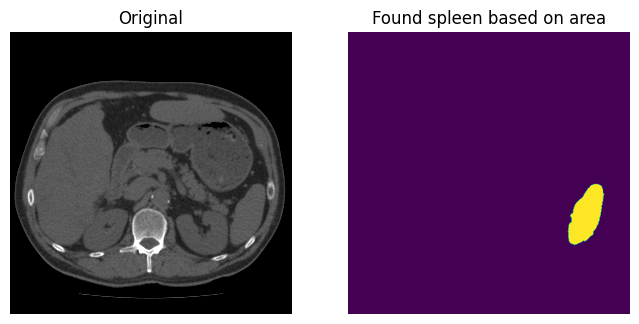

In [99]:
min_area = 2000
max_area = 10000
min_ecc = 0.90
max_perimeter = 350 

# Create a copy of the label_img
label_img_filter = label_img.copy()
region_props = measure.regionprops(label_img_filter)
for region in region_props:
	# Find the areas that do not fit our criteria
	if (region.area > max_area or region.area < min_area) or (region.eccentricity < min_ecc) or (region.perimeter > max_perimeter):
		# set the pixels in the invalid areas to background
		for cords in region.coords:
			label_img_filter[cords[0], cords[1]] = 0
# Create binary image from the filtered label image
i_area = label_img_filter > 0
show_comparison(img, i_area, 'Found spleen based on area')

##### Exercice 15:
Create a function spleen_finder(img) that takes as input a CT image and returns a binary image, where the pixels with value 1 represent the spleen and the pixels with value 0 everything else.

-3.0

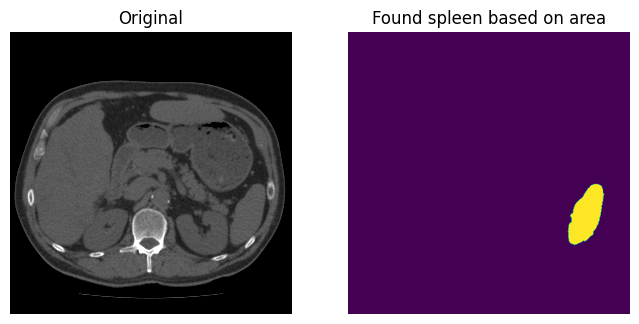

In [103]:
def spleen_finder(img):
    min_area = 2000
    max_area = 10000
    min_ecc = 0.90
    max_perimeter = 350 
    t_1 =  -3.0 #min(bins_spleen)
    t_2 =  99.0 #max(bins_spleen)
    
    # Creates the first estimation
    spleen_estimate = (img > t_1) & (img < t_2)
    # Applies morphological operations
    footprint = disk(1)
    closed = binary_closing(spleen_estimate, footprint)
    footprint = disk(4)
    opened = binary_opening(closed, footprint)
    # Made the labels and creates the region
    label_img = measure.label(opened)
    label_img_filter = label_img.copy()
    region_props = measure.regionprops(label_img_filter)
    for region in region_props:
        # Find the areas that do not fit our criteria
        if (region.area > max_area or region.area < min_area) or (region.eccentricity < min_ecc) or (region.perimeter > max_perimeter):
            # set the pixels in the invalid areas to background
            for cords in region.coords:
                label_img_filter[cords[0], cords[1]] = 0
    # Create binary image from the filtered label image
    i_area = label_img_filter > 0
    show_comparison(img, i_area, 'Found spleen based on area')
    return i_area

i_area = spleen_finder(img)

##### Exercise 16:
Test your function on the images called Validation1.dcm, Validation2.dcm and Validation3.dcm. Do you succeed in finding the spleen in all the validation images?

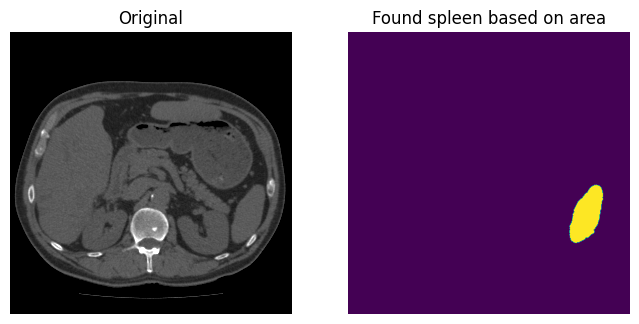

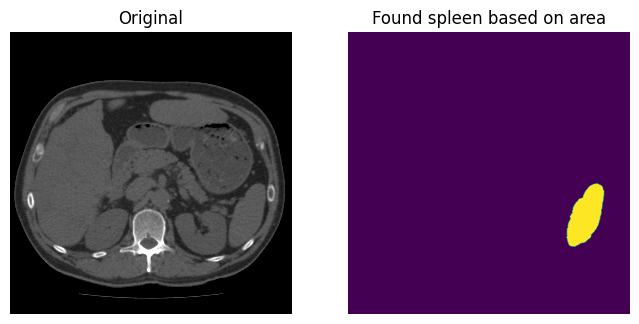

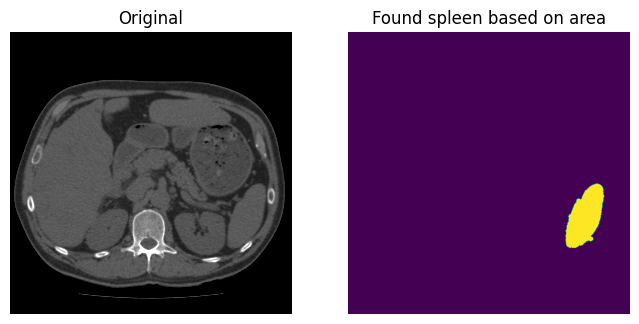

In [104]:
ct1 = dicom.read_file(in_dir + 'Validation1.dcm')
img1 = ct1.pixel_array

ct2 = dicom.read_file(in_dir + 'Validation2.dcm')
img2 = ct2.pixel_array

ct3 = dicom.read_file(in_dir + 'Validation3.dcm')
img3 = ct3.pixel_array

spleen_validation_1 = spleen_finder(img1)
spleen_validation_2 = spleen_finder(img2)
spleen_validation_3 = spleen_finder(img3)

#### DICE Score

We would like evaluate how good we are at finding the spleen by comparing our found spleen with ground truth annotations of the spleen. The DICE score (also called DICE coefficient or the DICE distance) is standard method of comparing one segmentation with another segmentation. 

If segmentation one is called X and the second segmentation called Y. The DICE socre is computed as:

$ DICE = \frac{2\left | X\cap Y \right |}{\left | X \right |+\left | Y \right |} $

where $\left | X\cap Y \right |$ is the area (in pixels) of the overlap of the two segmentations and is $\left | X \right | + \left | Y \right | $ the area of the union of the two segmentaion.

The DICE score is one if there is a perfect overlap between the two segmentations and zero if there is no overlap at all. A DICE score above 0.95 means that thw two segmentations are very similar.

Using SciPy we can compute the DICE score as:

In [105]:
ground_truth_img = io.imread(in_dir + 'Validation1_spleen.png')
gt_bin = ground_truth_img > 0
dice_score = 1 - distance.dice(i_area.ravel(), gt_bin.ravel())
print(f"DICE score {dice_score}")

DICE score 0.95870573594298


##### Exercise 17
Compute the DICCE score for your found spleen segmentations comapared to the ground truth segmentations for the three validation images. How high DICE scores do you achieve?

In [110]:
# Score for Validation 1
ground_truth_img = io.imread(in_dir + 'Validation1_spleen.png')
gt_bin = ground_truth_img > 0
dice_score_1 = 1 - distance.dice(spleen_validation_1.ravel(), gt_bin.ravel())
print(f"DICE score for Validation 1: {dice_score_1:.3f} ")

# Score for Validation 2
ground_truth_img = io.imread(in_dir + 'Validation2_spleen.png')
gt_bin = ground_truth_img > 0
dice_score_2 = 1 - distance.dice(spleen_validation_2.ravel(), gt_bin.ravel())
print(f"DICE score for Validation 2: {dice_score_2:.3f} ")

# Score for Validation 3
ground_truth_img = io.imread(in_dir + 'Validation3_spleen.png')
gt_bin = ground_truth_img > 0
dice_score_3 = 1 - distance.dice(spleen_validation_3.ravel(), gt_bin.ravel())
print(f"DICE score for Validation 3: {dice_score_3:.3f} ")

DICE score for Validation 1: 0.968 
DICE score for Validation 2: 0.973 
DICE score for Validation 3: 0.974 


#### Testing on an independent test set
Overfitting occurs when an algorithm has been developed on a training set and has become so specific to that set of data, that it works badly on other similar data. To avoid this, it is necessary to test an algorithm on an independent test set. We have provided three test images Test1.dcm, Test2.dcm and Test3.dcm with ground truth spleen annotations.

##### Exercise 18: 
Use your spleen finder program to find the spleen on the three test images and compute the DICE score. What is the result of your independent test?


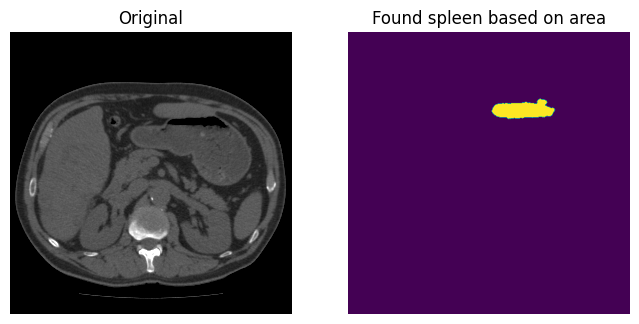

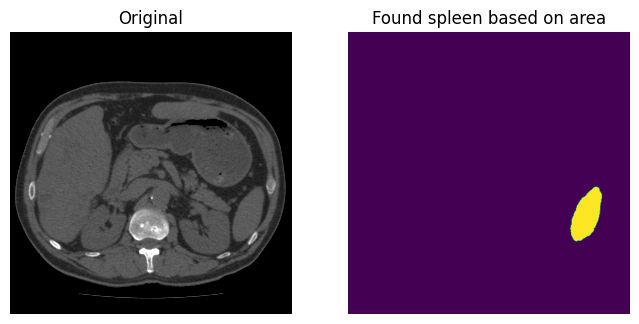

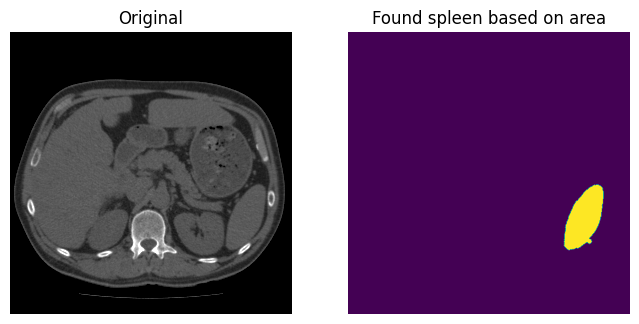

DICE score for test 1: 0.000 
DICE score for test 2: 0.961 
DICE score for test 3: 0.970 


In [111]:
ct1 = dicom.read_file(in_dir + 'Test1.dcm')
img1 = ct1.pixel_array

ct2 = dicom.read_file(in_dir + 'Test2.dcm')
img2 = ct2.pixel_array

ct3 = dicom.read_file(in_dir + 'Test3.dcm')
img3 = ct3.pixel_array

spleen_test_1 = spleen_finder(img1)
spleen_test_2 = spleen_finder(img2)
spleen_test_3 = spleen_finder(img3)

# Score for test 1
ground_truth_img = io.imread(in_dir + 'Test1_spleen.png')
gt_bin = ground_truth_img > 0
dice_score_1 = 1 - distance.dice(spleen_test_1.ravel(), gt_bin.ravel())
print(f"DICE score for test 1: {dice_score_1:.3f} ")

# Score for test 2
ground_truth_img = io.imread(in_dir + 'Test2_spleen.png')
gt_bin = ground_truth_img > 0
dice_score_2 = 1 - distance.dice(spleen_test_2.ravel(), gt_bin.ravel())
print(f"DICE score for test 2: {dice_score_2:.3f} ")

# Score for test 3
ground_truth_img = io.imread(in_dir + 'Test3_spleen.png')
gt_bin = ground_truth_img > 0
dice_score_3 = 1 - distance.dice(spleen_test_3.ravel(), gt_bin.ravel())
print(f"DICE score for test 3: {dice_score_3:.3f} ")